## Imports

In [ ]:
%cd Machine-learning-for-image-based-wavefront-sensing
import sys
from torchvision import transforms
from src.pytorch.dataset import *

import astropy.units as u
import pyoptica as po

import sys
import torchcd 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import OrderedDict
import torchvision

# Local import
from src.pytorch.models.Unet import UNet
from src.pytorch.models.Resnet import Net

from src.pytorch.train import *
from src.pytorch.lr_analyzer import *
from src.pytorch.criterion import *
import matplotlib.pyplot as plt
import random
from torchmetrics import MeanMetric
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import aotools

from tqdm import tqdm
import logging
import src.pytorch.utils as utils


import torchvision.transforms.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import random

from PIL import Image

## Functions

In [3]:

def plot_image(dataset):
    indx = random.randint(0,len(dataset))
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    im1 = axs[0].imshow(dataset[indx]['phase'].permute(1,2,0), cmap="jet")
    #set title wafront
    axs[0].set_title('Wavefront')
    #add colorbar
    plt.colorbar(im1, fraction=0.046)
    #add title to the colorbar [rad]
    im2 = axs[1].imshow(dataset[indx]['image'].permute(1,2,0), cmap="jet")
    plt.colorbar(im2, fraction=0.046)
    #set title psf
    axs[1].set_title('PSF')


def splitDataLoader(dataset, split=[0.8, 0.2], batch_size=32, random_seed=None, shuffle=True):

    len_train = int(np.floor(split[0] * len(dataset)))
    
    train_sampler, val_sampler = torch.utils.data.random_split(dataset, [len_train, len(dataset)-len_train])

    train_dataloader = DataLoader(train_sampler, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_sampler, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

def train_model(model, dataloader, optimizer, criterion, device="cuda", label_type = "zernike", factor = 1):

    loss_meter = MeanMetric(nan_strategy="error").to(device)

    model.train() 
    
    for data in tqdm(dataloader):


        inputs, y = data['image'], data[label_type]#[:, 1:]
            
        # move to gpu
        inputs = inputs.to(device)
        y = y.to(device)
        
        # Clear gradients.
        optimizer.zero_grad()

        dict_out = model(inputs)

        out = dict_out[label_type]
        # Compute the loss
        loss_factor = criterion(torch.squeeze(out), torch.squeeze(y*factor))

        with torch.no_grad():
            loss = criterion(torch.squeeze(out/factor), torch.squeeze(y))
            if label_type == "phase" and model.__class__.__name__ == "Net" :
                pred_z = dict_out['zernike']
                loss_z = criterion(torch.squeeze(pred_z),  data["zernike"][:, 1:].to(device))
                logging.info(f"train loss_z: {loss_z.mean().detach().item():.4f}")

                

        loss_meter.update(loss.detach())


        loss_factor.mean().backward() # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    
    logging.info(f"loss_factor: {loss_factor.mean().detach().item():.4f}")
    
    return loss_meter.compute().item()

def validate(model, dataloader, criterion, device="cuda", label_type = "zernike", factor = 1):

    loss_meter = MeanMetric(nan_strategy="error").to(device)

    model.eval()

    for data in tqdm(dataloader):

        inputs, y = data['image'], data[label_type]#[:, 1:]

        inputs = inputs.to(device)
        y = y.to(device)

        with torch.no_grad():

            dict_out = model(inputs)
            out = dict_out[label_type]  # Perform a single forward pass.

            loss = criterion(torch.squeeze(out/factor), torch.squeeze(y))

            if label_type == "phase" and model.__class__.__name__ == "Net":
                pred_z = dict_out['zernike']
                loss_z = criterion(torch.squeeze(pred_z),  data["zernike"][:, 1:].to(device))
                
                logging.info(f"val loss_z: {loss_z.mean().detach().item():.4f}")

        loss_meter.update(loss.detach())



    return loss_meter.compute().item()


        
def get_lr(optimizer):
    for p in optimizer.param_groups:
        lr = p['lr']
    return lr  




class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class modelDataset(Dataset):
    def __init__(self, images, data, label_type, trasform=False):
        self.images = images
        self.trasform = trasform
        if label_type != "zernike" and label_type != "phase":
            raise ValueError("label_type must be 'zern' or 'phase'")
        self.label_type = label_type
        self.data = pd.read_pickle(data)
        
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
            
            ])
        self.noise = transforms.Compose([
            AddGaussianNoise(0., 1.)
        ])

        #randm trasform
        self.rand_trasform = transforms.Compose([torchvision.transforms.RandAugment(),])

        self.resize = transforms.Compose([
            transforms.Resize((128,128)),])

        
    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):

        label = self.data.iloc[idx][self.label_type]
        dir = os.path.join(self.images, str(idx)+".png")
        image = Image.open(dir).convert('RGB')
        image = self.resize(image)
        if self.trasform: 
            if random.random() > 0.5:
                image = self.rand_trasform (image)
        image = self.normalize(image)
        #random gaussian if random > 0.5
        if self.trasform: 
            if random.random() > 0.5:
                image = self.noise(image)

            
        
        return {"image" : image, "zernike" : self.data.iloc[idx]["zernike"], "phase": self.data.iloc[idx]["phase"]}
    
def return_H_ZBasis(wavelength = 810 * u.nm, pixel_scale = 3.4 * u.um, npix = 128, na = 0.02, n_zernike= 11):
    x, y = po.utils.mesh_grid(npix, pixel_scale)
    f = po.utils.space2freq(x)
    g = po.utils.space2freq(y)
    # Calculate rho_squared in PyTorch
    rho_squared = f ** 2 + g ** 2

    # Define the threshold value
    threshold = (na / wavelength) ** 2

    # Use torch.where to create H
    H = torch.tensor(np.where(rho_squared < threshold, torch.tensor(1.0), torch.tensor(0.0)))

    rho, theta = po.utils.cart2pol(f, g)
    rho = rho.to(1 / u.m) / (na / wavelength).to(1 / u.m)

    z_basis = torch.tensor(np.array(([po.zernike(
                i, "noll", rho, theta, True, fill_value=False) for i in range(1, n_zernike+1)])))

    return H, z_basis


# Dataset

## Dataset values

In [139]:
import numpy as np
import astropy.units as u
import pyoptica as po
from astropy.io import fits
import time



# Parameters
wavelength = 810 * u.nm
pixel_scale = 3.4 * u.um
npix = 128
na = 0.02
coherence_factor = 1
n_zernike = 11
n_coefficients = list(range(1,n_zernike+1))

z_basis = aotools.zernikeArray(n_zernike, npix, norm='noll')

n_images = 10000

x, y = po.utils.mesh_grid(npix, pixel_scale)
r_max = .48 * npix * pixel_scale
r, theta = po.utils.cart2pol(x, y)
r = r / r_max

# Lists to store data for all images
wf_list = []
c_zernike_list = []
psf_abs_list = []

t0 = time.time()
n_fail = 0
# Loop to generate and store data
for i in range(n_images):
    # Generate random Zernike coefficients
    c_zernike = (np.random.random(n_zernike)*0.4 - 0.2)
    dict_zern = dict(zip(n_coefficients, c_zernike))
    dict_zern[1] = 0
    c_zernike = np.array(list(dict_zern.values()))

    # Create ImagingSystem instance
    img_system = po.ImagingSystem(wavelength, pixel_scale, npix, na=na, coherence_factor=coherence_factor)
    img_system.load_zernikes(dict_zern, 'noll')
    img_system.calculate()

    # Save
    outfile = "C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_10000/psf_" + str(i) + ".fits"


    output = c_zernike[:, None, None] * z_basis[None, :,:,:]
    wf = np.sum(output, axis=1).squeeze()
    
    hdu_primary = fits.PrimaryHDU(c_zernike.astype(np.float32))
    hdu_phase = fits.ImageHDU(wf.astype(np.float32), name='PHASE')
    hdu_PSF = fits.ImageHDU(np.abs(img_system.psf).astype(np.float32), name='PSF')
    hdu = fits.HDUList([hdu_primary, hdu_phase, hdu_PSF])
    hdu.writeto(outfile, overwrite=True)

    t_soapy = time.time() - t0
print('Propagation and saving finished in {0:2f}s'.format(t_soapy))
print('Failed: {0:2f}'.format(n_fail))

Propagation and saving finished in 193.345883s
Failed: 0.000000


## Dataset images

In [ ]:
import numpy as np
import astropy.units as u
import pyoptica as po
from astropy.io import fits
import time
import pandas as pd



# Parameters
wavelength = 810 * u.nm
pixel_scale = 3.4 * u.um
npix = 128
na = 0.02
coherence_factor = 1
n_zernike = 11
n_coefficients = list(range(1,n_zernike+1))

z_basis = aotools.zernikeArray(n_zernike, npix, norm='noll')

n_images = 1000

x, y = po.utils.mesh_grid(npix, pixel_scale)
r_max = .48 * npix * pixel_scale
r, theta = po.utils.cart2pol(x, y)
r = r / r_max

data = []


t0 = time.time()
n_fail = 0
# Loop to generate and store data
for i in range(n_images):
    # Generate random Zernike coefficients
    c_zernike = (np.random.random(n_zernike)*0.4 - 0.2)
    dict_zern = dict(zip(n_coefficients, c_zernike))
    dict_zern[1] = 0
    c_zernike = np.array(list(dict_zern.values()))

    # Create ImagingSystem instance
    img_system = po.ImagingSystem(wavelength, pixel_scale, npix, na=na, coherence_factor=coherence_factor)
    img_system.load_zernikes(dict_zern, 'noll')
    img_system.calculate()

    psf = img_system.plot(psf=dict(log_scale=False, cmap="jet", title="", colorbar=False), fig_options=dict(dpi=130))
    #plt.figure(figsize=(224/my_dpi, 224/my_dpi), dpi=my_dpi)
    psf = plt.imshow(np.abs(img_system.psf), cmap="jet")
    #define figsize
    plt.axis("off")
    psf.set_clim(8.316885e-08, 0.0089)
    plt.savefig(f"C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_images/no_log/{str(i)}.png", bbox_inches ='tight')

    psf2 = img_system.plot(psf=dict(log_scale=True, cmap="jet", title="", colorbar=False), fig_options=dict(dpi=130))
    #plt.figure(figsize=(224/my_dpi, 224/my_dpi), dpi=my_dpi)
    psf2 = plt.imshow(np.log(np.abs(img_system.psf)), cmap="jet")
    plt.axis("off")
    psf2.set_clim(-16.302393, -4.0794506)
    plt.savefig(f"C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_images/log/{str(i)}.png", bbox_inches ='tight')



    output = c_zernike[:, None, None] * z_basis[None, :,:,:]
    wf = np.sum(output, axis=1).squeeze()

    data.append({"id":i, "zernike": c_zernike.astype(np.float32), "phase": wf.astype(np.float32), "pdf": np.abs(img_system.psf).astype(np.float32)})
    plt.clf()

    t_soapy = time.time() - t0
df = pd.DataFrame(data)
print('Propagation and saving finished in {0:2f}s'.format(t_soapy))
print('Failed: {0:2f}'.format(n_fail))

#save df as pikle
df.to_pickle("C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_images/data.pkl")

# Resnet18 Zernike input: value of PSF

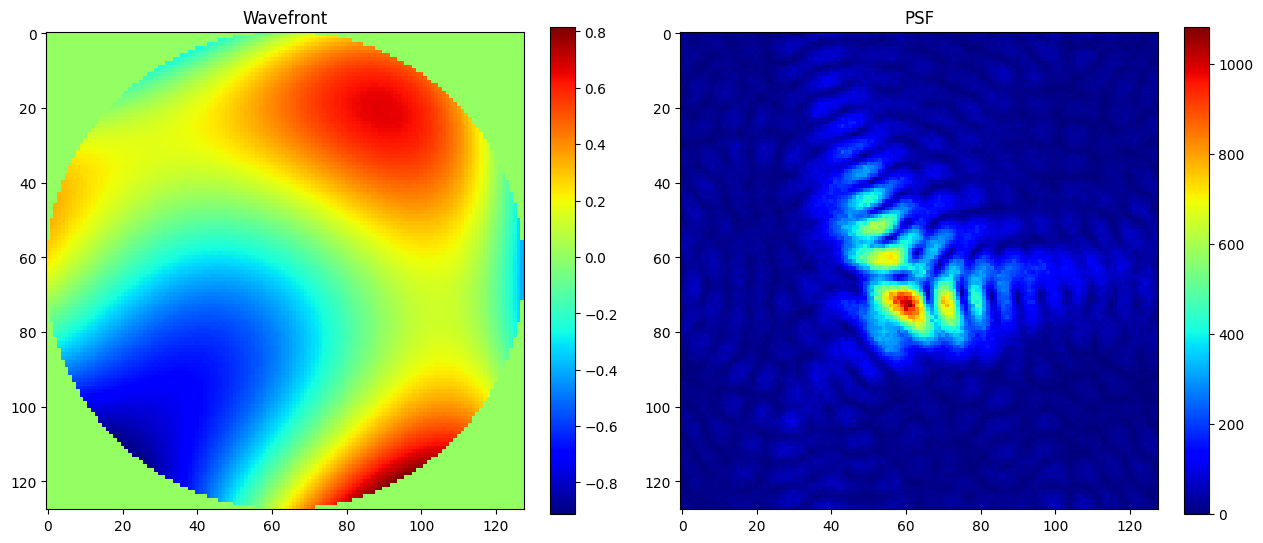

In [73]:

data_dir = 'C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4/'
dataset = psf_dataset(root_dir = data_dir,
                      transform = transforms.Compose([Noise(), Normalize(), ToTensor()]))

plot_image(dataset)

## Train

In [11]:

wand = False 
num_epochs = 100
split=[0.8, 0.2]
batch_size = 16
best_loss = 0.0
factor = 100

name = "resnet18_MSE_0.4zern_factor100_noimage"


model_dir='./'
log_path = os.path.join(model_dir, 'logs.log')
utils.set_logger(log_path)
metrics_path = os.path.join(model_dir, f'metrics_{name}.json')

if wand:
    wandb.init(project="wave")

    if wandb.run.get_url() == '':
        logging.warning("Running *without* WandB logging.")
    else:
        logging.info(f"Logging this run to {wandb.run.get_url()}.")

dataloader_train, dataloader_val = splitDataLoader(dataset, split=split, batch_size=batch_size, random_seed=None, shuffle=True)

#model
model = Net(label_type="zern", input_type="psf", model_size=18, p_drop=0.70, n_zernike=10, npx = 128).cuda()


criterion = nn.MSELoss(reduction='none')
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.9, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [10, 50])

metrics = {
    'model': model_dir,
    'optimizer': optimizer.__class__.__name__,
    'criterion': criterion.__class__.__name__,
    'scheduler': scheduler.__class__.__name__,
    'dataset_size': int(len(dataset)),
    'train_size': int(split[0]*len(dataset)),
    'test_size': int(split[1]*len(dataset)),
    'n_epoch': num_epochs,
    'batch_size': batch_size,
    'learning_rate': [],
    'train_loss': [],
    'val_loss': [],
    'zernike_train_loss': [],
    'zernike_val_loss': []
}

for epoch in range(0, num_epochs):

    logging.info('-'*30)
    train_loss = train_model(model, dataloader_train, optimizer, criterion, factor=factor)
    metrics['zernike_train_loss'].append(train_loss)


    vall_loss = validate(model, dataloader_val, criterion, factor = factor)
    metrics['zernike_val_loss'].append(vall_loss)
    metrics['learning_rate'].append(get_lr(optimizer))

    scheduler.step()



    logging.info(f"Epoch {epoch+1:3d}: ")
    logging.info(f"Train loss: {train_loss:.4f}")
    logging.info(f"Val loss: {vall_loss:.4f}")

    if epoch == 0 or vall_loss < best_loss:
        best_loss = vall_loss
        model_path = os.path.join(model_dir, f'{name}.pth')
        torch.save(model.state_dict(), model_path)

    # Save metrics
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4) 

    if wand:

        wandb.log({
            "train/loss": train_loss,
            "val/loss": vall_loss,
        }, step=epoch)




------------------------------
100%|██████████| 50/50 [00:05<00:00,  9.72it/s]
loss_factor: 139.8806
100%|██████████| 13/13 [00:00<00:00, 13.06it/s]
Epoch   1: 
Train loss: 0.0132
Val loss: 0.0124
------------------------------
100%|██████████| 50/50 [00:04<00:00, 10.93it/s]
loss_factor: 96.8251
100%|██████████| 13/13 [00:00<00:00, 13.41it/s]
Epoch   2: 
Train loss: 0.0116
Val loss: 0.0101
------------------------------
100%|██████████| 50/50 [00:04<00:00, 11.03it/s]
loss_factor: 106.5426
100%|██████████| 13/13 [00:00<00:00, 13.18it/s]
Epoch   3: 
Train loss: 0.0098
Val loss: 0.0088
------------------------------
100%|██████████| 50/50 [00:04<00:00, 10.87it/s]
loss_factor: 86.2555
100%|██████████| 13/13 [00:00<00:00, 13.18it/s]
Epoch   4: 
Train loss: 0.0090
Val loss: 0.0082
------------------------------
100%|██████████| 50/50 [00:04<00:00, 11.02it/s]
loss_factor: 85.2392
100%|██████████| 13/13 [00:01<00:00, 12.86it/s]
Epoch   5: 
Train loss: 0.0087
Val loss: 0.0080
------------------

# Resnet18 Zernike input: image

In [12]:
images = "C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_images/no_log"
data = "C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_images/data.pkl"
dataset = modelDataset(images = images, data = data, label_type="zernike", trasform=True)

In [ ]:

wand = False 
num_epochs = 100
split=[0.8, 0.2]
batch_size = 16
best_loss = 0.0
factor = 100

name = "resnet18_MSE_0.4zern_factor100_image"


model_dir='./'
log_path = os.path.join(model_dir, 'logs.log')
utils.set_logger(log_path)
metrics_path = os.path.join(model_dir, f'metrics_{name}.json')

if wand:
    wandb.init(project="wave")

    if wandb.run.get_url() == '':
        logging.warning("Running *without* WandB logging.")
    else:
        logging.info(f"Logging this run to {wandb.run.get_url()}.")

dataloader_train, dataloader_val = splitDataLoader(dataset, split=split, batch_size=batch_size, random_seed=None, shuffle=True)

#model
model = Net(label_type="zern", input_type="image", model_size=18, p_drop=0.50, n_zernike=10, npx = 128).cuda()


criterion = nn.MSELoss(reduction='none')
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.9, weight_decay = 5e-4)
#adam
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [10])
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-7, last_epoch=-1)

metrics = {
    'model': model_dir,
    'optimizer': optimizer.__class__.__name__,
    'criterion': criterion.__class__.__name__,
    'scheduler': scheduler.__class__.__name__,
    'dataset_size': int(len(dataset)),
    'train_size': int(split[0]*len(dataset)),
    'test_size': int(split[1]*len(dataset)),
    'n_epoch': num_epochs,
    'batch_size': batch_size,
    'learning_rate': [],
    'train_loss': [],
    'val_loss': [],
    'zernike_train_loss': [],
    'zernike_val_loss': []
}


for epoch in range(0, num_epochs):

    logging.info('-'*30)
    train_loss = train_model(model, dataloader_train, optimizer, criterion, factor=factor)
    metrics['zernike_train_loss'].append(train_loss)


    vall_loss = validate(model, dataloader_val, criterion, factor = factor)
    metrics['zernike_val_loss'].append(vall_loss)
    metrics['learning_rate'].append(get_lr(optimizer))

    scheduler.step()



    logging.info(f"Epoch {epoch:3d}: ")
    logging.info(f"Train loss: {train_loss:.4f}")
    logging.info(f"Val loss: {vall_loss:.4f}")

    if epoch == 0 or vall_loss < best_loss:
        best_loss = vall_loss
        model_path = os.path.join(model_dir, f'{name}.pth')
        torch.save(model.state_dict(), model_path)

    # Save metrics
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4) 

    if wand:

        wandb.log({
            "train/loss": train_loss,
            "val/loss": vall_loss,
        }, step=epoch)


# Unet Zernike input: value

In [69]:

data_dir = 'C:/Users/UTENTE/Desktop/wavefront/Machine-learning-for-image-based-wavefront-sensing/data_0.4_10000/'
dataset = psf_dataset(root_dir = data_dir,
                      transform = transforms.Compose([Noise(), Normalize(), ToTensor()]))

In [ ]:

wand = False 
num_epochs = 100
split=[0.8, 0.2]
batch_size = 64
best_loss = 0.0
factor = 10

name = f"Unet_MSE_0.4phase_factor{factor}_values_10000"


model_dir='./'
log_path = os.path.join(model_dir, 'logs.log')
utils.set_logger(log_path)
metrics_path = os.path.join(model_dir, f'metrics_{name}.json')

if wand:
    wandb.init(project="wave")

    if wandb.run.get_url() == '':
        logging.warning("Running *without* WandB logging.")
    else:
        logging.info(f"Logging this run to {wandb.run.get_url()}.")

dataloader_train, dataloader_val = splitDataLoader(dataset, split=split, batch_size=batch_size, random_seed=None, shuffle=True)

#model
model  = UNet(1,1).cuda()


criterion = nn.MSELoss(reduction='none')
#optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9, weight_decay = 5e-4)
#adam
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 75])
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-7, last_epoch=-1)
#linear
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(dataloader_train), epochs=num_epochs)

metrics = {
    'model': model_dir,
    'optimizer': optimizer.__class__.__name__,
    'criterion': criterion.__class__.__name__,
    'scheduler': scheduler.__class__.__name__,
    'dataset_size': int(len(dataset)),
    'train_size': int(split[0]*len(dataset)),
    'test_size': int(split[1]*len(dataset)),
    'n_epoch': num_epochs,
    'batch_size': batch_size,
    'learning_rate': [],
    'train_loss': [],
    'val_loss': [],
    'zernike_train_loss': [],
    'zernike_val_loss': []
}


for epoch in range(0, num_epochs):

    logging.info('-'*30)
    train_loss = train_model(model, dataloader_train, optimizer, criterion, label_type="phase", factor=factor)
    metrics['zernike_train_loss'].append(train_loss)


    vall_loss = validate(model, dataloader_val, criterion, label_type="phase", factor = factor)
    metrics['zernike_val_loss'].append(vall_loss)
    metrics['learning_rate'].append(get_lr(optimizer))

    scheduler.step()



    logging.info(f"Epoch {epoch+1:3d}: ")
    logging.info(f"Train loss: {train_loss:.4f}")
    logging.info(f"Val loss: {vall_loss:.4f}")

    if epoch == 0 or vall_loss < best_loss:
        best_loss = vall_loss
        model_path = os.path.join(model_dir, f'{name}.pth')
        torch.save(model.state_dict(), model_path)

    # Save metrics
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4) 

    if wand:

        wandb.log({
            "train/loss": train_loss,
            "val/loss": vall_loss,
        }, step=epoch)


# Eval

In [70]:
model = UNet(1,1)

model_dir = 'C:/Users/UTENTE/Desktop/wavefront/_Machine-learning-for-image-based-wavefront-sensing/UNet_MSE_0.4phase_factor10_values.pth'
state_dict = torch.load(model_dir, map_location='cpu')
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove module.
    new_state_dict[name] = v
model.load_state_dict(state_dict)
model = model.cuda()

In [71]:
model = Net(label_type="zernike", input_type="psf", model_size=50, p_drop=0.0, n_zernike=10, npx = 128).cuda()

model_dir = 'C:/Users/UTENTE/Desktop/wavefront/_Machine-learning-for-image-based-wavefront-sensing/Net_MSE_0.4phase_factor100_layernorm_values_10000.pth'
state_dict = torch.load(model_dir, map_location='cpu')
model.load_state_dict(state_dict)
model = model.cuda()

C:\Users\UTENTE\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\UTENTE\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


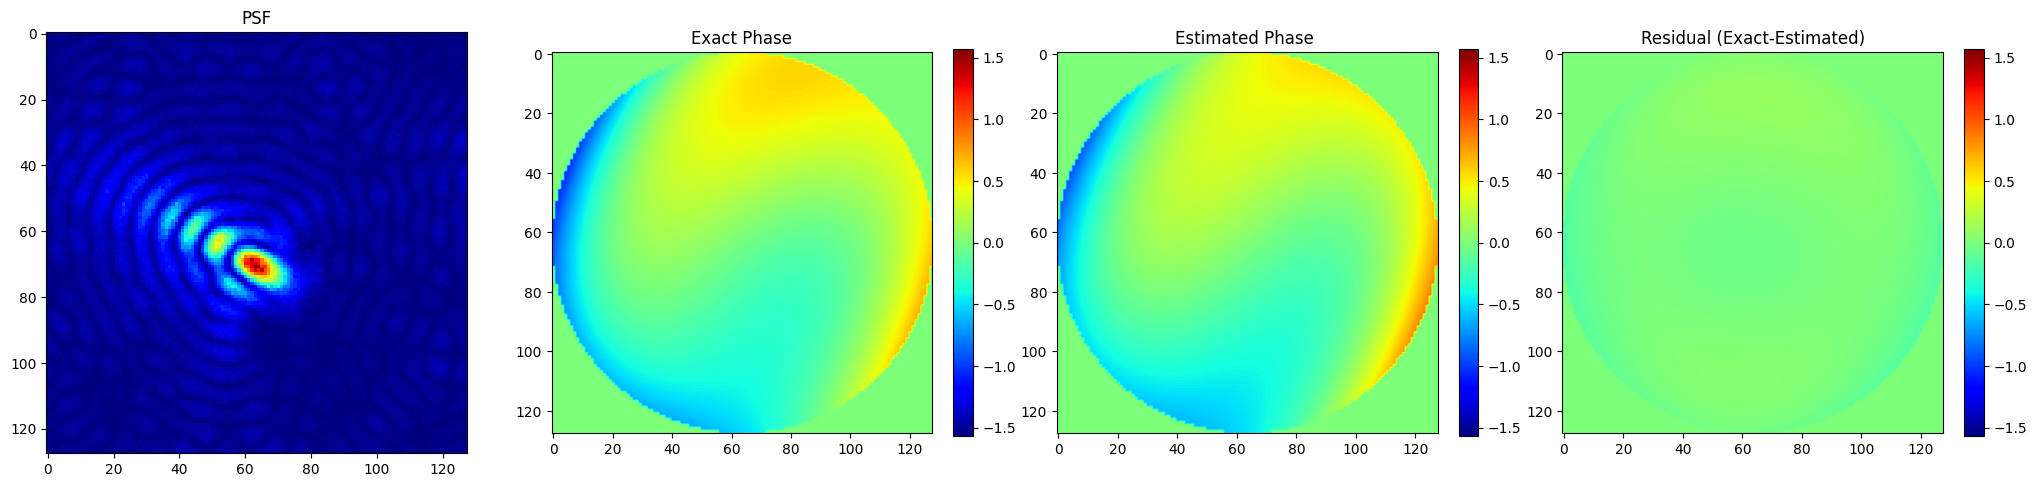

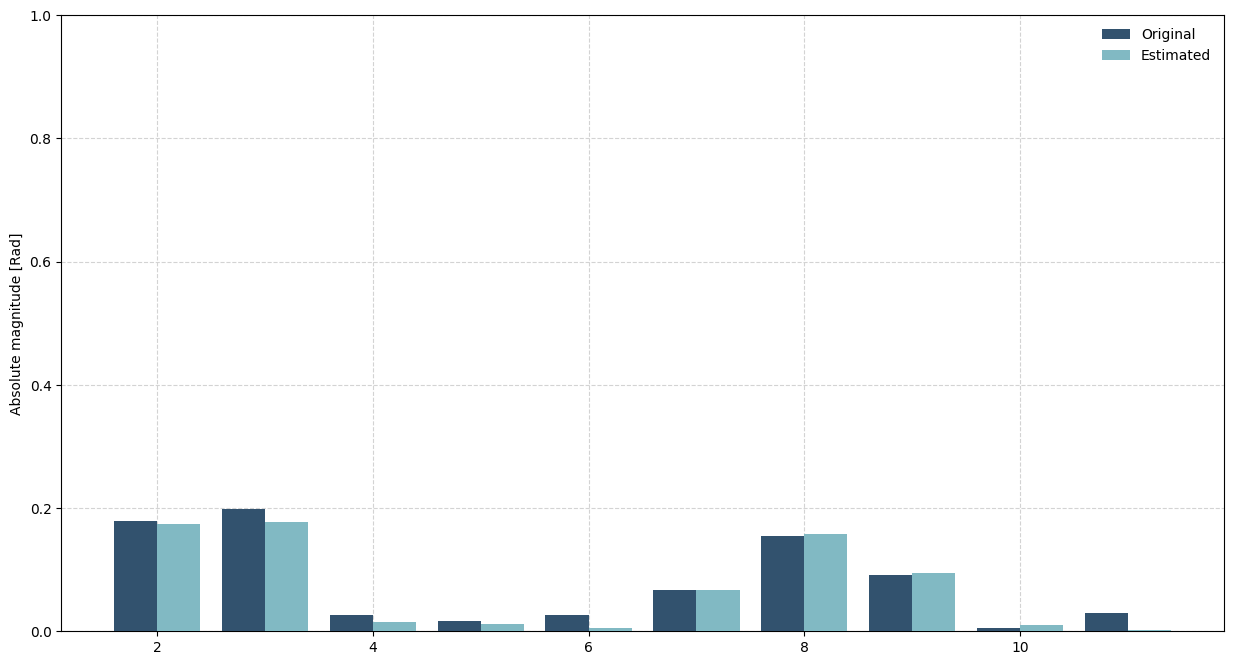

WFE MSE:  0.0019320236904882505 [Rad]
WFE MSE:  0.6764804651260725 [nm]
Zernike MSE:  0.00024487336157432034 [Rad]
Zernike MSE:  0.08574017303738055 [nm]
strhel:  0.9565792738101554


In [94]:
# Network prediction
factor = 100
# Forward pass and get phase estimation
# Need to expand firts dimension to match batch format
# [batch]x[channel]x[dim_x]x[dim_y]
model.eval()
id = random.randint(0,len(dataset))
sample = dataset[233] 
input = sample['image'].unsqueeze(0).cuda()
z_coeffs_est = model(input)['zernike'].detach().cpu().numpy()/factor

z_coeffs_est = np.insert(z_coeffs_est, 0, 0)
n_zernike = 11
npix = 128
z_basis = aotools.zernikeArray(n_zernike, npix, norm='noll')
output = z_coeffs_est[:, None, None] * z_basis[None, :,:,:]
wf = np.sum(output, axis=1).squeeze()

#wf = model(input)['phase'].detach().cpu().numpy()/factor


phase = sample['phase']
#output_numpy = output.detach().numpy()[0][0]
phase_est = np.ma.array(wf.squeeze(), mask=(phase==0).squeeze().detach().cpu().numpy())
phase_est = phase_est.filled(fill_value=0)
phase = sample['phase']
# Plot network output
f, axarr = plt.subplots(1, 4, figsize=(25, 10))
im0 = axarr[0].imshow(input.cpu().squeeze(), cmap=plt.cm.jet)
axarr[0].set_title("PSF")
#plt.colorbar(im0, ax = axarr[0], fraction=0.046)


im1 = axarr[1].imshow(phase.squeeze(), cmap=plt.cm.jet)
im1.set_clim(-np.pi/2, np.pi/2)
axarr[1].set_title("Exact Phase")
plt.colorbar(im1, ax = axarr[1], fraction=0.046)
im2 = axarr[2].imshow(phase_est, cmap=plt.cm.jet)
im2.set_clim(-np.pi/2, np.pi/2)
axarr[2].set_title("Estimated Phase ")
plt.colorbar(im2, ax = axarr[2], fraction=0.046)
im3 = axarr[3].imshow((phase.numpy()-phase_est).squeeze(), cmap=plt.cm.jet)
im3.set_clim(-np.pi/2, np.pi/2)

axarr[3].set_title("Residual (Exact-Estimated)")
plt.colorbar(im3, ax = axarr[3], fraction=0.046)
plt.show()

z_basis = aotools.zernikeArray(11, 128, norm='noll')  # [rad]

criterion = nn.MSELoss(reduction='none')

# 2) Define Standard Dot product
def frobeniusInnerProduct(A, B):
    fIProduct = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            fIProduct += A[i, j]*B[i, j]
    return fIProduct

# 3) Project
z_norm = np.empty([10])
z_coeffs = np.empty([10])
z_coeffs_est = np.empty([10])
z_coeffs_res = np.empty([10])
for i in range(10):
    z_norm[i] = frobeniusInnerProduct(z_basis[i+1,:,:], z_basis[i+1,:,:])
    z_coeffs[i] = frobeniusInnerProduct(phase.squeeze().numpy(), z_basis[i+1,:,:]) / z_norm[i]
    z_coeffs_est[i] = frobeniusInnerProduct(phase_est, z_basis[i+1,:,:]) / z_norm[i]
    z_coeffs_res[i] = frobeniusInnerProduct((phase.numpy()-phase_est).squeeze(), z_basis[i+1,:,:]) / z_norm[i]

# 4) Plot
colors2 = ['#669f61','#ff884d','#32526e','#81b9c3','#41c3ac']
nbr = 10
i_zernike = np.arange(2, nbr+2)
f, ax = plt.subplots(1, 1, figsize=(15, 8))
w = 0.4
#plot input
ax.bar(i_zernike-w/2, np.abs(z_coeffs[0:nbr]),  width=w, label='Original', color=colors2[2],zorder=3)
ax.bar(i_zernike +w/2, np.abs(z_coeffs_est[0:nbr]),  width=w, label='Estimated', color=colors2[3],zorder=3)
ax.set_ylabel('Absolute magnitude [Rad]')
ax.legend(fancybox=False, frameon=False)
#ax[1].bar(i_zernike-w/2, np.abs(z_coeffs[nbr:2*nbr]),  width=w, label='Original', color=colors2[2],zorder=3)
#ax[1].bar(i_zernike +w/2, np.abs(z_coeffs_est[nbr:2*nbr]), width=w, label='Estimated', color=colors2[3],zorder=3)
#ax[1].set_ylabel('Absolute magnitude [Rad]')
#ax[1].set_xlabel("Zernike indices")
#ax[1].set_xticks(np.arange(2, nbr+2)[0::4])
#ax[1].set_xticklabels(np.arange(nbr+2, nbr+nbr+2)[0::4])
ax.set_ylim(0, 1)
#ax[1].set_ylim(0,0.45)
ax.grid(zorder=0, color='lightgray', linestyle='--')
#ax[1].grid(zorder=0, color='lightgray', linestyle='--')
plt.show() 
sys.path.insert(0, '../src/algorithms/')
from src.pytorch.utils import *
from src.pytorch.criterion import *

# Wavefront root mean squared error over the phase map (pixel wise) [Rad]
rmse_wfe =  criterion(phase.squeeze(0), torch.tensor(phase_est).squeeze(0)).numpy().mean().item()
print("WFE MSE: ", rmse_wfe, "[Rad]")
print("WFE MSE: ", 2200*rmse_wfe/(2*np.pi), "[nm]")

# Wavefront root mean squared error (wfe rmse) [Rad]
rmse_zernike = criterion(torch.tensor(z_coeffs).squeeze(0), torch.tensor(z_coeffs_est).squeeze(0)).mean().item()
print("Zernike MSE: ", rmse_zernike, "[Rad]")
print("Zernike MSE: ", 2200*rmse_zernike/(2*np.pi), "[nm]")

wavelength = 810 * u.nm
pixel_scale = 3.4 * u.um
npix = 128
na = 0.02
coherence_factor = 1
n_zernike = 11
n_coefficients = list(range(1,n_zernike+1))

z_basis = aotools.zernikeArray(n_zernike, npix, norm='noll')

n_images = 10000

x, y = po.utils.mesh_grid(npix, pixel_scale)
r_max = .48 * npix * pixel_scale
r, theta = po.utils.cart2pol(x, y)
r = r / r_max

# Lists to store data for all images
wf_list = []
c_zernike_list = []
psf_abs_list = []

t0 = time.time()
n_fail = 0
# Loop to generate and store data

# Generate random Zernike coefficients
#c_zernike = (np.random.random(n_zernike)*0.4 - 0.2)
c_zernike = np.zeros(n_zernike)
dict_zern = dict(zip(n_coefficients, c_zernike))
dict_zern[1] = 0
c_zernike = np.array(list(dict_zern.values()))

# Create ImagingSystem instance
img_system = po.ImagingSystem(wavelength, pixel_scale, npix, na=na, coherence_factor=coherence_factor)
img_system.load_zernikes(dict_zern, 'noll')
img_system.calculate()

psfMax = (np.abs(img_system.psf)).max()

c_zernike = np.insert(z_coeffs_res, 0, 0)
dict_zern = dict(zip(n_coefficients, c_zernike))
dict_zern[1] = 0
img_system.load_zernikes(dict_zern, 'noll')
img_system.calculate()

detector = (np.abs(img_system.psf))

instStrehl = detector.max() / psfMax

print("strhel: ", instStrehl)